In [3]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%matplotlib inline

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.2 scipy==1.7.3 pandas==1.2.1 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.7
squidpy==1.2.2


### Load Dataset

In [7]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
#img = sq.datasets.visium_fluo_image_crop()
adata_sc = sq.datasets.sc_mouse_cortex()

  0%|          | 0.00/3.03G [00:00<?, ?B/s]

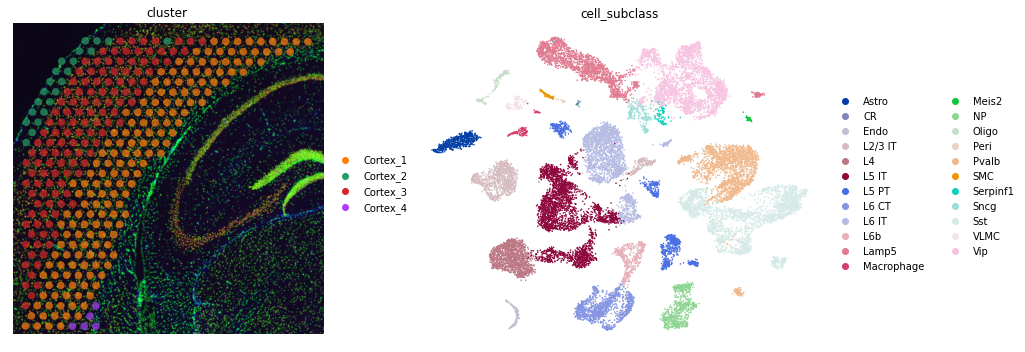

In [8]:
# sc.settings.set_figure_params(figsize=(5, 5), dpi=100)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

In [9]:
adata_sc

AnnData object with n_obs × n_vars = 21697 × 36826
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
adata_st

AnnData object with n_obs × n_vars = 324 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Get Training Genes and preprocessing

In [11]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

In [12]:
# 1. Takes a list of genes from user via the genes argument. These genes are used as training genes.
# 2. Annotates training genes under the training_genes field, in uns dictionary, of each AnnData.
# 3. Ensure consistent gene order in the datasets (Tangram requires that the the j-th column in each matrix correspond to the same gene).
# 4. If the counts for a gene are all zeros in one of the datasets, the gene is removed from the training genes.
# 5. If a gene is not present in both datasets, the gene is removed from the training genes.

tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [13]:
adata_st.var_names

Index(['xkr4', 'gm19938', 'sox17', 'mrpl15', 'lypla1', 'tcea1', 'rgs20',
       'atp6v1h', 'oprk1', 'npbwr1',
       ...
       'mt-nd5', 'mt-nd6', 'mt-cytb', 'caaa01118383.1', 'vamp7', 'spry3',
       'tmlhe', '4933409k07rik', 'caaa01147332.1', 'ac149090.1'],
      dtype='object', length=16174)

In [14]:
adata_st.raw.var_names

Index(['Xkr4', 'Gm19938', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20',
       'Atp6v1h', 'Oprk1', 'Npbwr1',
       ...
       'mt-Nd5', 'mt-Nd6', 'mt-Cytb', 'CAAA01118383.1', 'Vamp7', 'Spry3',
       'Tmlhe', '4933409K07Rik', 'CAAA01147332.1', 'AC149090.1'],
      dtype='object', length=16562)

In [15]:
adata_st

AnnData object with n_obs × n_vars = 324 × 16174
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'training_genes', 'overlap_genes'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:
## uniform density
res1 = 1/adata_st.shape[0]

## rna_count_based_density
rna_count_per_spot = np.array(adata_st.X.sum(axis=1)).squeeze()
res2 = rna_count_per_spot / np.sum(rna_count_per_spot)

### Alignment





map_cells_to_space(cell * spot)  ==> project_cell_annotations(spot * cell_cluster)

In [17]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


In [13]:
ad_map

AnnData object with n_obs × n_vars = 21697 × 324
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [18]:
ad_map.X.sum(axis=1)

array([1.0000002 , 1.0000002 , 1.0000002 , ..., 0.99999976, 1.        ,
       1.0000001 ], dtype=float32)

In [19]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [20]:
adata_st.obsm['tangram_ct_pred']

Pvalb         L4        Vip    L2/3 IT     Lamp5  \
AAATGGCATGTCTTGT-1   6.162955   0.003784   7.129545   0.660758  4.017167   
AACAACTGGTAGTTGC-1   5.935681   0.001970  13.671297   0.003887  5.972416   
AACAGGAAATCGAATA-1   4.947017   0.012543   7.511800   0.003163  6.249305   
AACCCAGAGACGGAGA-1   9.825101   3.144581   3.577537   6.210446  8.225604   
AACCGTTGTGTTTGCT-1  10.346286   5.678318   5.488540   0.469932  4.572013   
...                       ...        ...        ...        ...       ...   
TTGGATTGGGTACCAC-1   5.276813   1.010203  13.867637   1.604263  2.414389   
TTGGCTCGCATGAGAC-1   3.406033   3.810423   6.476522  12.135788  7.850851   
TTGTATCACACAGAAT-1   4.702185   0.679636   6.906719   0.427020  4.425425   
TTGTGGCCCTGACAGT-1   8.126913   3.483702   9.941195   0.005873  1.002438   
TTGTTAGCAAATTCGA-1   3.989680  21.912531   5.864890   1.862221  1.667833   

                          NP        Sst      L5 IT     Oligo      L6 CT  ...  \
AAATGGCATGTCTTGT-1  3.216856   4.051904   4.930536  0.007131   8.824871  ...   
AACAACTGGTAGTTGC-1  3.535395   4.184813   9.701370  0.432183   2.388703  ...   
AACAGGAAATCGAATA-1  0.007367   8.799052   6.009745  0.483605  14.022086  ...   
AACCCAGAGACGGAGA-1  0.001204   7.146122   9.657464  0.571293   1.542442  ...   
AACCGTTGTGTTTGCT-1  0.767359   6.772423  13.463670  1.514640   0.001302  ...   
...                      ...        ...        ...       ...        ...  ...   
TTGGATTGGGTACCAC-1  2.076682  13.818554  10.188562  0.348901   0.818319  ...   
TTGGCTCGCATGAGAC-1  0.001456  10.866405   8.570868  0.172741   1.143870  ...   
TTGTATCACACAGAAT-1  3.277315   7.887295   7.830670  0.539954   5.991231  ...   
TTGTGGCCCTGACAGT-1  0.877166   5.731449   3.714697  0.822647   6.631963  ...   
TTGTTAGCAAATTCGA-1  0.002136   5.574974  14.772472  0.742964   0.002285  ...   

                       L5 PT     Astro       L6b      Endo      Peri  \
AAATGGCATGTCTTGT-1  7.743512  2.604133  0.002027  0.409344  0.000167   
AACAACTGGTAGTTGC-1  6.893543  1.948666  1.775140  0.540059  0.126582   
AACAGGAAATCGAATA-1  1.063943  2.092959  0.321320  0.533106  0.200491   
AACCCAGAGACGGAGA-1  0.168683  2.870972  0.002271  0.570790  0.000288   
AACCGTTGTGTTTGCT-1  2.370414  1.114507  1.091907  1.575087  0.072231   
...                      ...       ...       ...       ...       ...   
TTGGATTGGGTACCAC-1  6.349622  2.525969  0.000992  0.486355  0.049685   
TTGGCTCGCATGAGAC-1  0.001980  0.929985  0.923764  0.406904  0.057488   
TTGTATCACACAGAAT-1  4.370423  0.765606  1.814933  0.408710  0.068161   
TTGTGGCCCTGACAGT-1  2.335812  2.100518  1.306225  0.672952  0.044280   
TTGTTAGCAAATTCGA-1  0.515523  1.353678  0.000758  0.514409  0.105368   

                       Meis2  Macrophage        CR      VLMC       SMC  
AAATGGCATGTCTTGT-1  0.000189    1.272541  0.000445  0.206644  0.673154  
AACAACTGGTAGTTGC-1  0.002406    0.561213  0.092594  0.000411  0.242247  
AACAGGAAATCGAATA-1  0.959066    0.688024  0.009159  0.000379  0.268722  
AACCCAGAGACGGAGA-1  0.083222    0.903755  0.000161  0.572019  0.575752  
AACCGTTGTGTTTGCT-1  0.001294    0.199300  0.061398  0.000262  0.504438  
...                      ...         ...       ...       ...       ...  
TTGGATTGGGTACCAC-1  0.000204    0.169865  0.000796  0.266679  0.727170  
TTGGCTCGCATGAGAC-1  0.022943    0.301968  0.006766  0.235634  0.415811  
TTGTATCACACAGAAT-1  0.001577    0.172124  0.041419  0.180348  0.275209  
TTGTGGCCCTGACAGT-1  0.000103    0.667069  0.000385  0.361348  0.273064  
TTGTTAGCAAATTCGA-1  0.000238    0.117512  0.000647  0.201439  0.150094  

[324 rows x 23 columns]

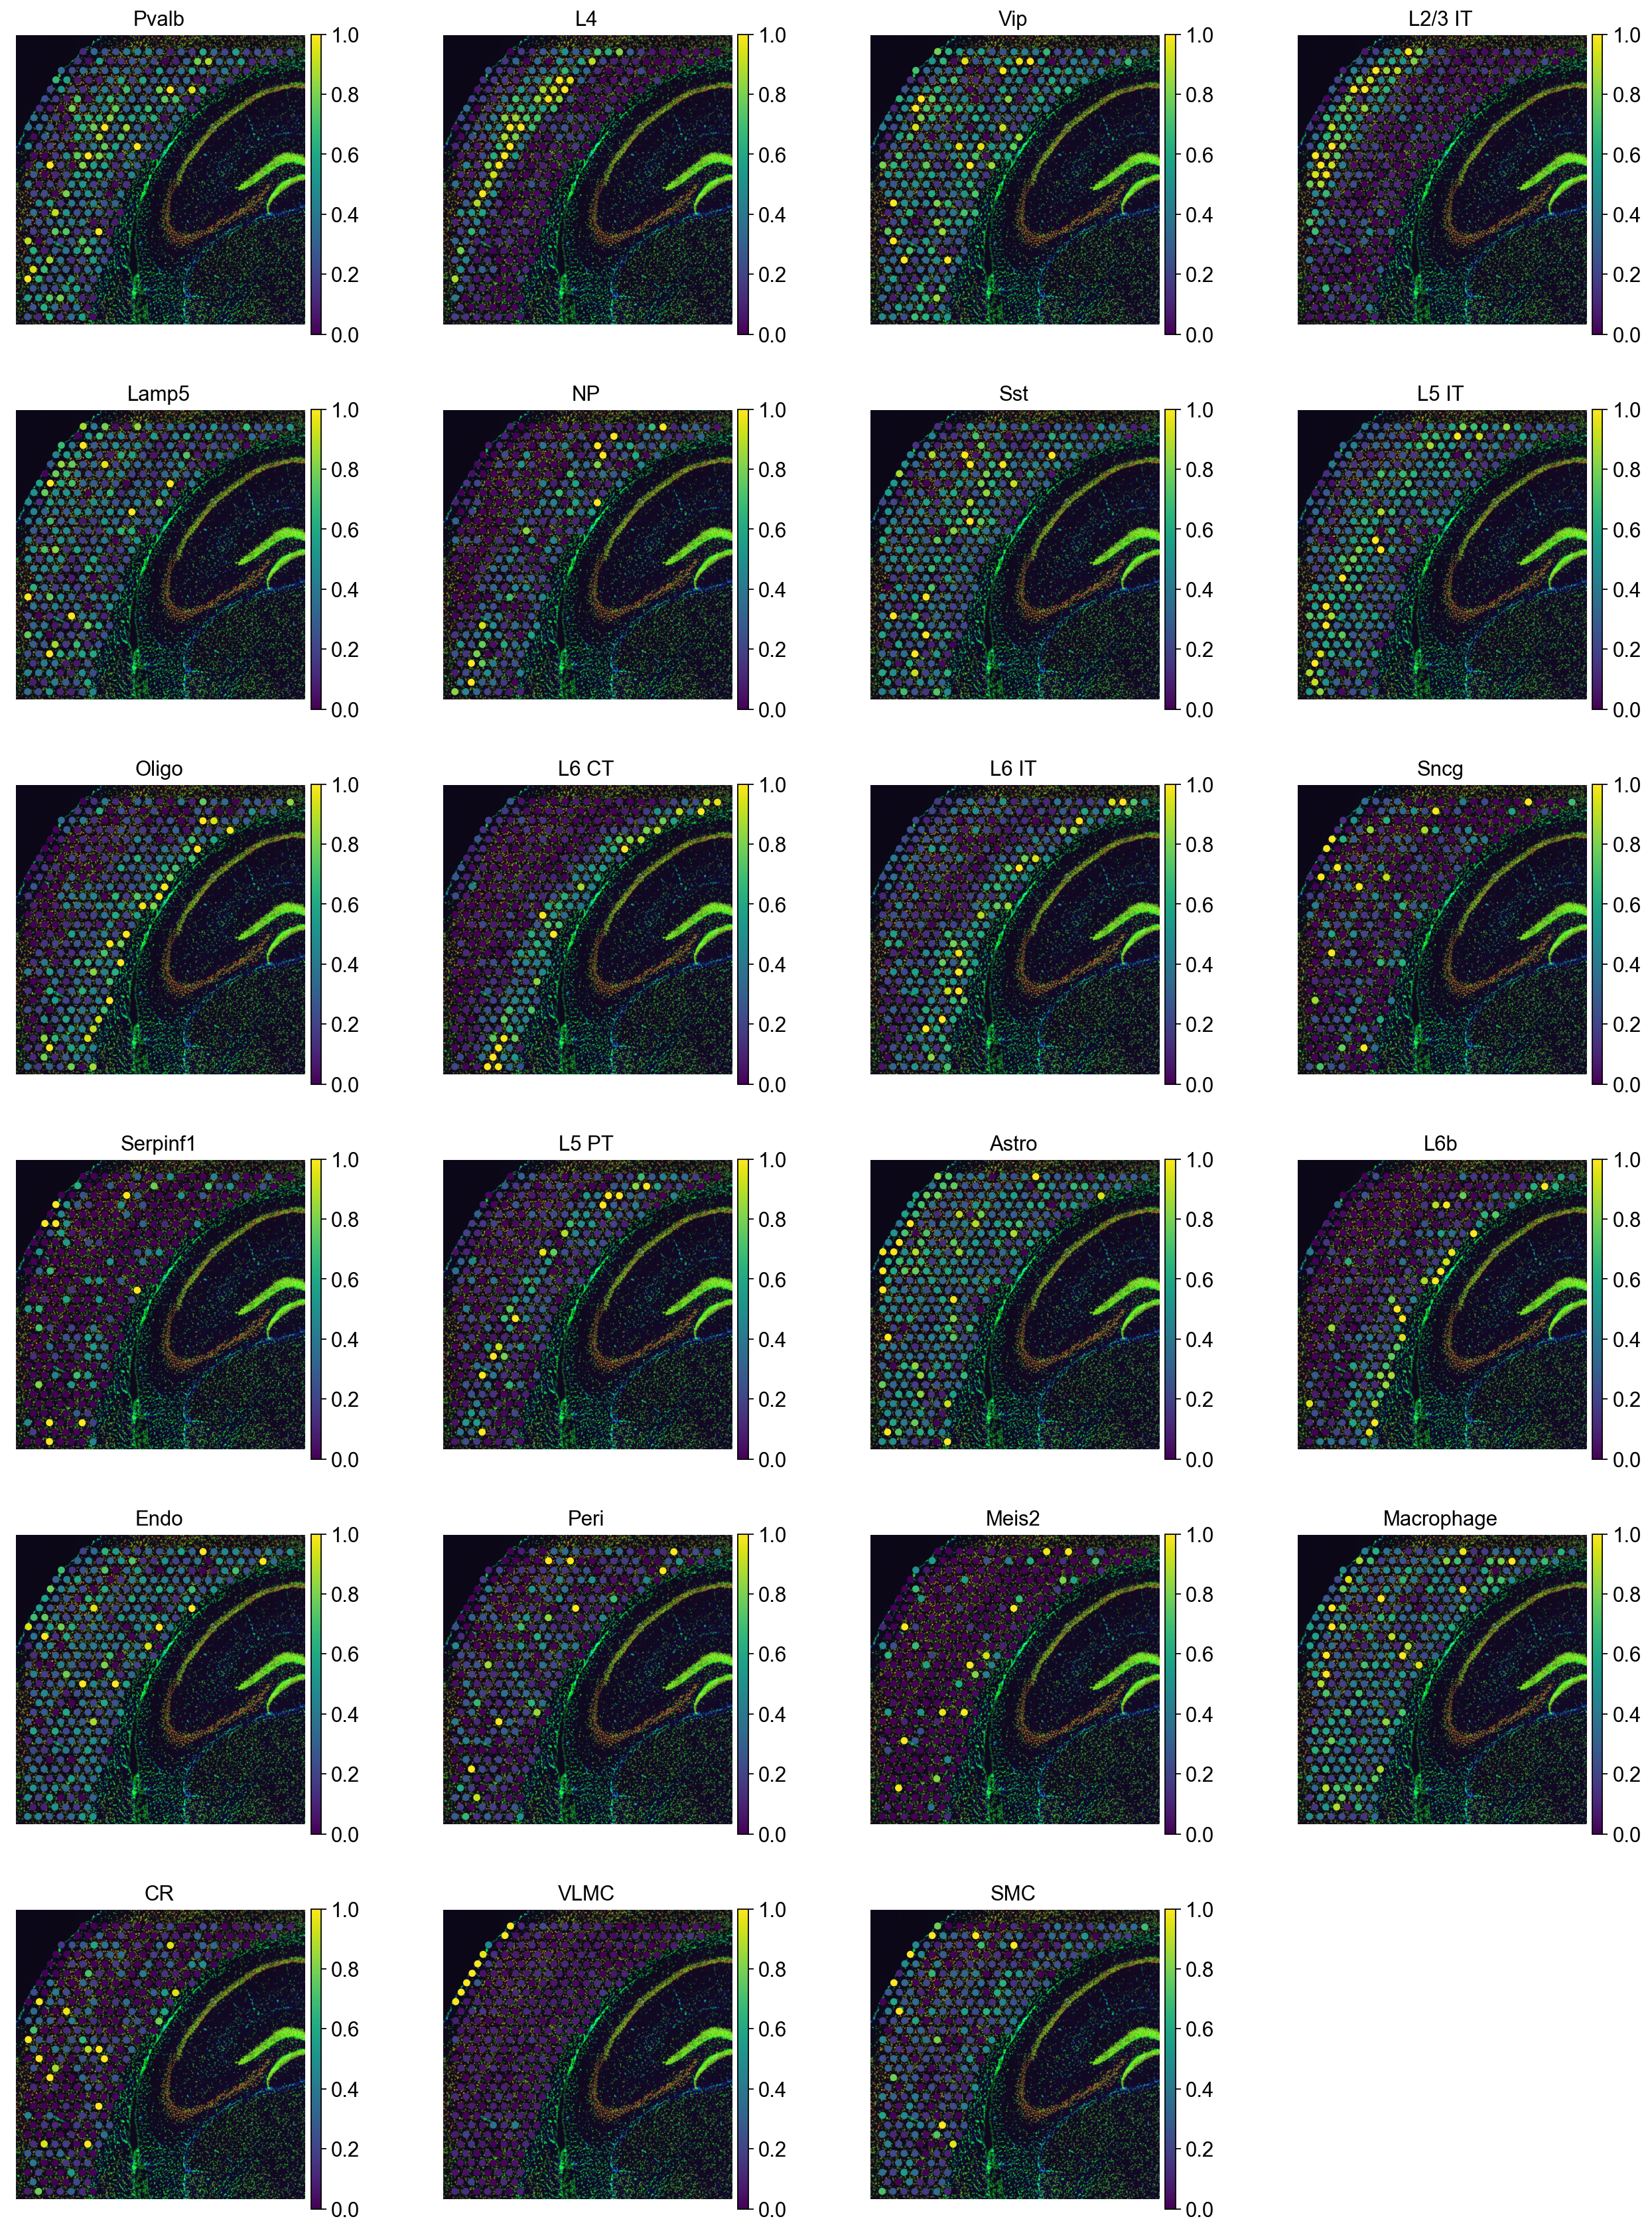

In [21]:
sc.settings.set_figure_params(figsize=(4, 4))
tg.plot_cell_annotation_sc(adata_st, annotation_list, perc=0.02, 
                           scale_factor=adata_st.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['scalefactors']['tissue_hires_scalef'])

In [22]:
from tangram.plot_utils import construct_obs_plot
def plot_cell_annotation_sc(
    adata_sp, 
    annotation_list, 
    x="x", 
    y="y", 
    spot_size=None, 
    scale_factor=0.1, 
    perc=0,
    ncols=5,
    cmap='viridis',
    ax=None
):
        
    # remove previous df_plot in obs
    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)
    # construct df_plot
    df = adata_sp.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(df, adata_sp, perc=perc)
    sc.pl.spatial(
        adata_sp, color=annotation_list, show=False, frameon=False, spot_size=spot_size, scale_factor=scale_factor, ax=ax, cmap=cmap, ncols=ncols
    )

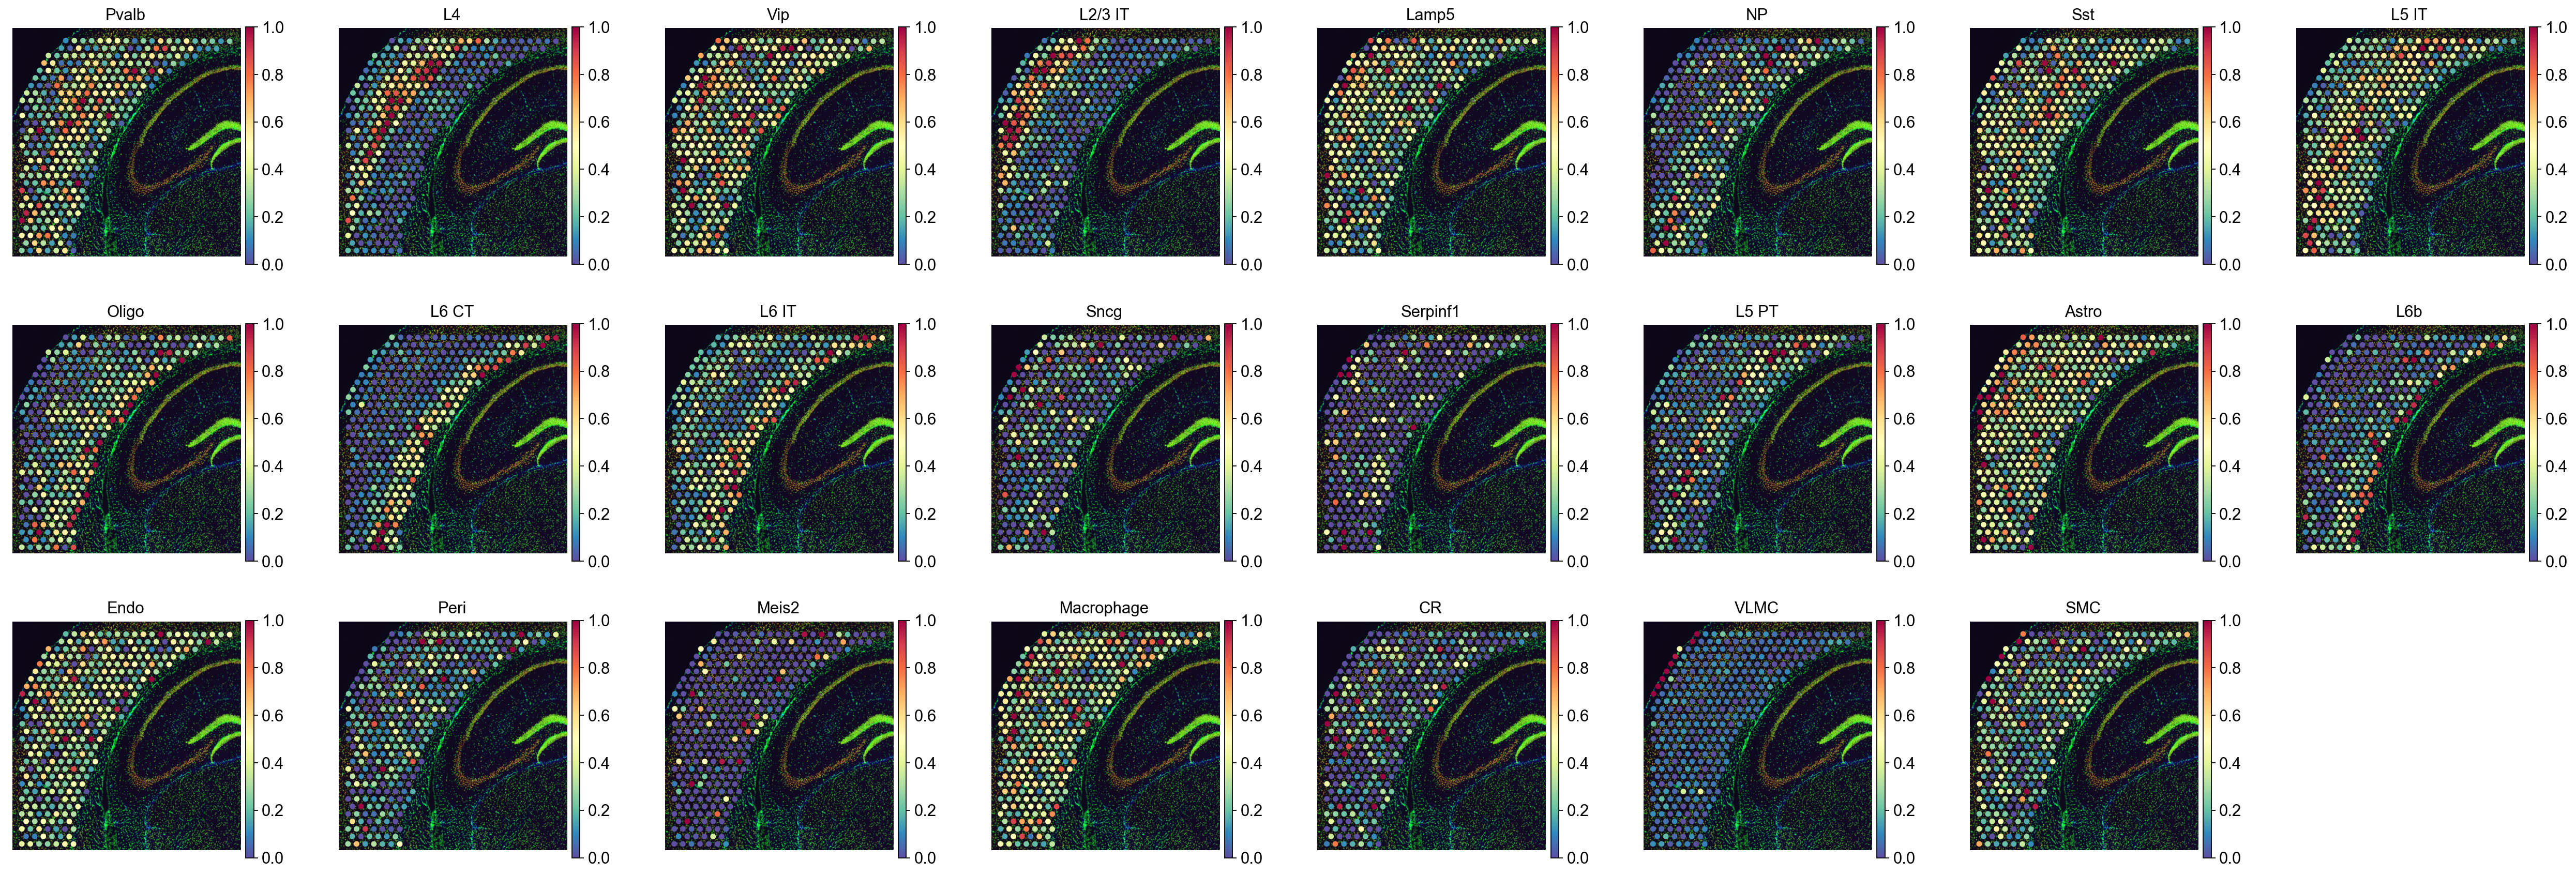

In [23]:
plot_cell_annotation_sc(adata_st, annotation_list,perc=0.02, cmap='Spectral_r', ncols=8,
                           scale_factor=adata_st.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['scalefactors']['tissue_hires_scalef'])

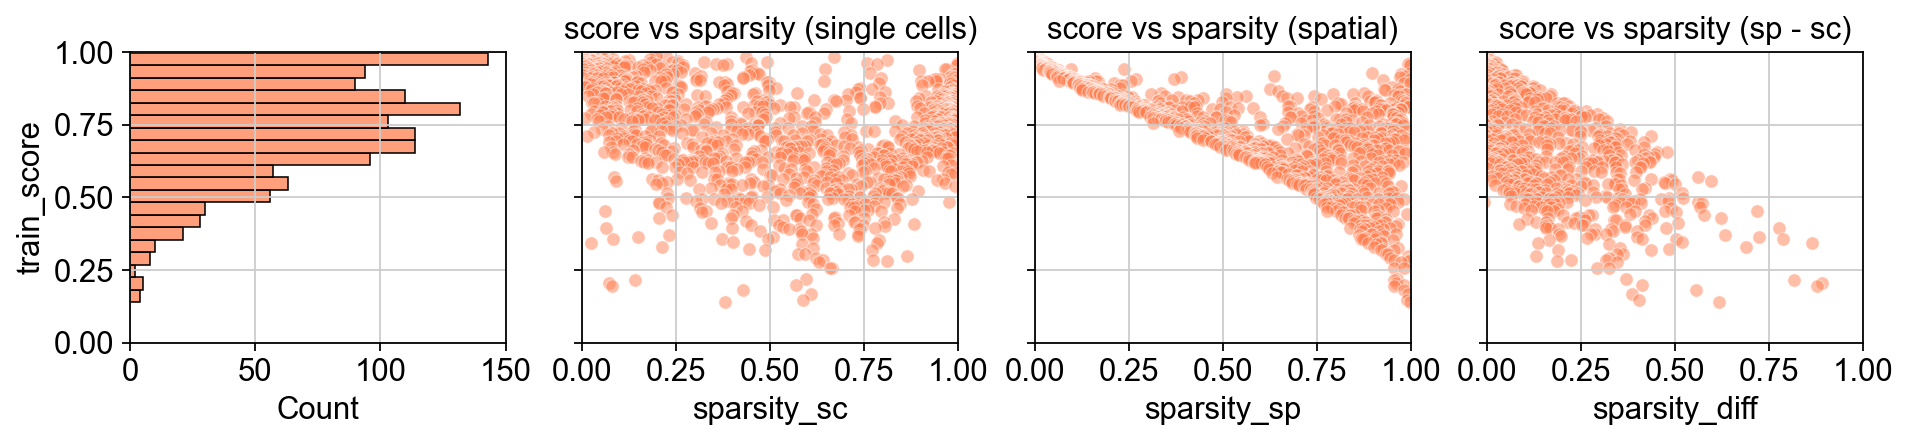

In [24]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [25]:
ad_map.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
ppia         0.998201     0.000092     0.000000      -0.000092
ubb          0.997341     0.000092     0.000000      -0.000092
atp1b1       0.997038     0.014334     0.000000      -0.014334
tmsb4x       0.996963     0.002811     0.000000      -0.002811
ckb          0.996335     0.002765     0.000000      -0.002765
...               ...          ...          ...            ...
gabrb2       0.195704     0.078951     0.956790       0.877839
cdyl2        0.181896     0.425911     0.981481       0.555570
cntnap5c     0.167591     0.608241     0.993827       0.385586
dlx1as       0.144945     0.587777     0.990741       0.402964
kcnh6        0.139091     0.379131     0.996914       0.617783

[1280 rows x 4 columns]